##### Copyright 2019 The TensorFlow Authors.

In [259]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [260]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [261]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [262]:
print(tf.__version__)

2.19.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [263]:
dataset_name = "LeTest"

In [264]:
# url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# dataset = tf.keras.utils.get_file("aclImdb_v1", url,
#                                     untar=True, cache_dir='datasets',
#                                     cache_subdir='')
dataset_dir = '/home/maes/sandbox/snortdev/model/datasets/'+dataset_name
# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1')

In [265]:
os.listdir(dataset_dir)

['test', 'train']

In [266]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg', 'pos']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [267]:
sample_file = os.path.join(train_dir, 'pos/5.txt')
with open(sample_file) as f:
  print(f.read())

nuda drudes


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [268]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/home/maes/sandbox/snortdev/model/datasets/LeTest/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 21746 files belonging to 2 classes.
Using 17397 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [269]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'1%");call regexp_substring(repeat(left(crypt_key(char(65)||char(69)||char(83),null),0),500000000),null)--'
Label 0
Review b"-1692') union all select 7074,7074,7074,7074,7074,7074,7074#"
Label 0
Review b'14412'
Label 1


Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [270]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [271]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/home/maes/sandbox/snortdev/model/datasets/LeTest/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 21746 files belonging to 2 classes.
Using 4349 files for validation.


In [272]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/home/maes/sandbox/snortdev/model/datasets/LeTest/train',
    batch_size=batch_size)

Found 21746 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [273]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [274]:
max_features = 100000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [275]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [276]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [277]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'sant josep de sa talaia', shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[ 197,  613,   19, 4096, 3439,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [278]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  larenas
 313 --->  manuel
Vocabulary size: 19631


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [279]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [280]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [281]:
embedding_dim = 16

In [282]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [283]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [284]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.6459 - loss: 0.6443 - val_binary_accuracy: 0.6528 - val_loss: 0.6283
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.6532 - loss: 0.6254 - val_binary_accuracy: 0.6528 - val_loss: 0.5985
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.6688 - loss: 0.5900 - val_binary_accuracy: 0.7172 - val_loss: 0.5352
Epoch 4/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.7485 - loss: 0.5255 - val_binary_accuracy: 0.7806 - val_loss: 0.4520
Epoch 5/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.8221 - loss: 0.4436 - val_binary_accuracy: 0.8124 - val_loss: 0.3800
Epoch 6/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.8691 - loss: 0.3692 - val_binary_accuracy: 0.8788 - val_loss: 0.3127
Epoch 7/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9059 - loss: 0.3077 - val_binary_accuracy: 0.8894 - val_loss: 0.2657
Epoch 

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [285]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - binary_accuracy: 0.9437 - loss: 0.1862
Loss:  0.1839669644832611
Accuracy:  0.9435758590698242


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [286]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

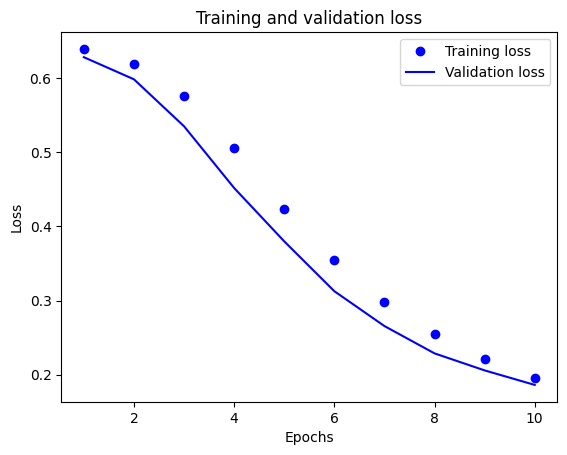

In [287]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

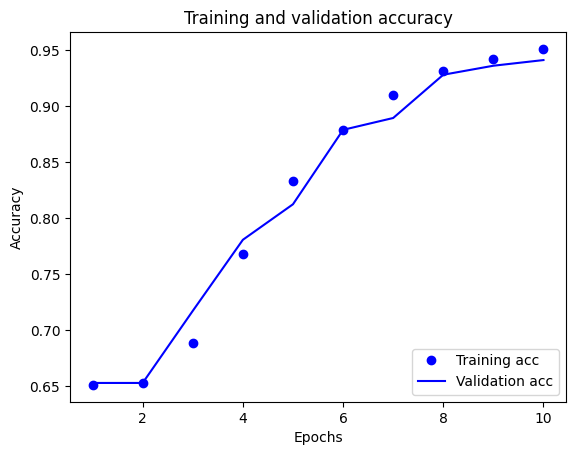

In [288]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [289]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  # layers.Activation('tanh')
])

# export_model.compile(
#     loss=losses.BinaryCrossentropy(), optimizer="adam", metrics=['accuracy']
# )
export_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])


# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

680/680 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - binary_accuracy: 0.9434 - loss: 0.1865
{'binary_accuracy': 0.9435758590698242, 'loss': 0.18396703898906708}


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [290]:
examples = tf.constant([
  "cd /var",
  "c/ toledo 22,",
  "chr(60)||chr(58)||chr(113)||chr(113)||chr(112)||chr(106)||chr(113)",
  "1'))) or 8466=benchmark(5000000,md5(0x694a4745)) and ((('gbhd'='gbhd",
  "../../../var/",
  "ll aclImdb",
  "cat aclImdb/imdb.vocab ",
  "%27%--",
  "-3930%"")) order by 1#",
  "usb c",
  "iphone 14",
  " 1 OR 1==1--",
  "%04x%f03",
  "main(argc[2])",
  "') where 2090=2090;select count(*) from generate_series(1,5000000)--"
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


array([[0.9375923 ],
       [0.95716196],
       [0.9381955 ],
       [0.14036849],
       [0.9381955 ],
       [0.9375923 ],
       [0.9375923 ],
       [0.9422235 ],
       [0.57188594],
       [0.95428   ],
       [0.9416475 ],
       [0.48772776],
       [0.93819547],
       [0.93819547],
       [0.37624165]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

In [302]:
export_archive = tf.keras.export.ExportArchive()
export_archive.track(model)
export_archive.add_endpoint(
    name='serve',
    fn=model.call,
    input_signature=[tf.TensorSpec(shape=(1, sequence_length), dtype=tf.int32)],
)
export_archive.write_out('../trained-models/temp/')

converter = tf.lite.TFLiteConverter.from_saved_model('../trained-models/temp/')

classifier_model = converter.convert()

with open('../trained-models/snort-http-classifier-example.model', 'wb') as f:
    f.write(classifier_model)


INFO:tensorflow:Assets written to: ../trained-models/temp/assets


INFO:tensorflow:Assets written to: ../trained-models/temp/assets


Saved artifact at '../trained-models/temp/'. The following endpoints are available:

* Endpoint 'serve'
  inputs (POSITIONAL_OR_KEYWORD): TensorSpec(shape=(1, 300), dtype=tf.int32, name=None)
  training (POSITIONAL_OR_KEYWORD): Literal[None]
  mask (POSITIONAL_OR_KEYWORD): Literal[None]
Output Type:
  TensorSpec(shape=(1, 1), dtype=tf.float32, name=None)
Captures:
  139983460213456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139983460214992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139983460213264: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1752047810.907786   45725 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752047810.907807   45725 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-09 09:56:50.907969: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../trained-models/temp/
2025-07-09 09:56:50.908588: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-09 09:56:50.908595: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: ../trained-models/temp/
2025-07-09 09:56:50.911545: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-09 09:56:50.933976: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: ../trained-models/temp/
2025-07-09 09:56:50.939915: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 31949 microseconds.
2025-07-09 09:56:51.0352

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.


In [299]:
source = '../trained-models/snort-http-classifier-example.model'

destination = '../../lab/snort/host-volume/snort-http-classifier.model'
shutil.copy(source, destination)

shutil.rmtree('../trained-models/temp')